In [34]:
%matplotlib inline
import pylab as plt
import blimpy
from blimpy import Waterfall
from blimpy import calcload
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats import norm, kurtosis, kurtosistest
import scipy
import numpy.ma as ma
import seaborn as sns

In [3]:
file_path = '/lustre/aoc/students/jsofair/playing-with-cosmic-data/filterbank/'
filelist = glob.glob(os.path.join(file_path,'*.fil'))

ml_list = []
for i, file in enumerate(filelist):
    ml = blimpy.calcload.calc_max_load(os.path.join(file))
    ml_list.append(ml)
    print(f'{ml} -- {file[65:]}')

9.0 -- Band_Test_BD_C512-beam0001.fil
8.0 -- band_test_AC_C512-beam0001.fil
11.0 -- Band_Test_BD_C0-beam0001.fil
7.0 -- band_test_GPU3_BD_C32-beam0001.fil
11.0 -- band_test_AC_C32-beam0001.fil
4.0 -- band_test_AC_C544-beam0001.fil


In [4]:
t0 = time.time()
water0 = Waterfall(os.path.normpath(filelist[0]), max_load = ml_list[0])
water1 = Waterfall(os.path.normpath(filelist[1]), max_load = ml_list[1])
water2 = Waterfall(os.path.normpath(filelist[2]), max_load = ml_list[2])
water3 = Waterfall(os.path.normpath(filelist[3]), max_load = ml_list[3])
water4 = Waterfall(os.path.normpath(filelist[4]), max_load = ml_list[4])
water5 = Waterfall(os.path.normpath(filelist[5]), max_load = ml_list[5])

water_list = [water0, water1, water2, water3, water4, water5]
t1 = time.time()
print(f'Elapsed time: {t1 - t0}')

Elapsed time: 79.01174235343933


In [5]:
water0.info()


--- File Info ---
      machine_id :                                0
    telescope_id :                               -1
         src_raj :                 4:09:22.00873993
         src_dej :                12:17:39.84749624
        az_start :             6.9287069824102e-310
        za_start :             4.6633787335631e-310
       data_type :                                1
            fch1 :           3532.4999961853027 MHz
            foff :           -7.62939453125e-06 MHz
          nchans :                          4194304
          nbeams :                                2
           ibeam :                                1
           nbits :                               32
   tstart (ISOT) :          2023-05-10T22:08:42.502
    tstart (MJD) :               60074.922714145854
           tsamp :                         0.131072
            nifs :                                1
     barycentric :                                1
   pulsarcentric :                           

---
**Self-made kurtosis plot(s)?** Here's my plan:
- Break up waterN.freqs into channels of width w
- Calculate the kurtosis of each channel
- Create an array that contains all channels with kurtosis > 0 (the Fisher definition is used by default)
- Compare these channels with Dept. of Commerce graph to see where RFI might be coming in
- Will also compare to waterN+1.freqs, etc. to see common threads to identify RFI

**Step 1:** Break up waterN.freqs into channels of potentially distinct widths w_n

In [22]:
'''
Getting channel borders.

For now, this is all just using water0. Eventually, I want this to hit the point
where it will go through all N of the .fil files
'''


min_f = int(np.round(water0.get_freqs()[len(water0.get_freqs())-1]))
# print(min_f)
max_f = int(np.round(water0.get_freqs()[0]))
# print(max_f)

# Create an array of channel borders for each .fil file
all_channels = []

# Specify the number of channels to break each .fil file into
num_chnls = 1398101
# print(len(water_list))

for i in range(0, len(water_list)):
#     print('h')
    exec(f'all_channels.append(np.array_split(water{i}.get_freqs(), {num_chnls}))')
    


# all_channels is X by Y by Z:
# X fil files,
# Y divisions per fil file,
# Z elements per division (Z is different for each division unless the fil files are divided evenly).

# Thus, all_channels[i][j] is a channel.
# For example, all_channels[0][3] takes the 3rd channel by index from water0.
# Another example: all_channels[0][3][1] takes the 1st measured frequency by index from the above channel.

In [7]:
# for i in range(0, len(water_list)):
#     exec(f'water{i}_channels = []')
#     exec(f'all_channels.append(water{i}_channels)')
    
print(max_f, min_f)
# Add channel divisions to an array
# for j in enumerate(range(min_f, max_f, 5)):
#     freq = j[1]
#     exec(f'water{0}_channels.append(freq)')
    
# for i, freq in enumerate(range(0, len(water_list))):
#     for j in enumerate(range(min_f, max_f, 10)):
#         print(freq)
#         exec(f'water{i}_channels.append(freq)')

# for i, freq in enumerate(range(0, len(water_list))):
#     for j in enumerate(range(min_f, max_f, 10)):

# print(all_channels)
# print(water0_channels)

3532 3501


**Step 2:** Calculate the kurtosis of each channel

In [13]:
print(kurtosis(all_channels[0][0]),
np.amax(all_channels[0][0]),
np.amin(all_channels[0][0]))

print(len(all_channels[0][0]), all_channels[0][0][0], all_channels[0][0][1])

-1.2000000000136428 3532.4999961853027 3529.2999992370605
419431 3532.4999961853027 3532.499988555908


In [23]:
kurts = []

for i, chnl in enumerate(all_channels[0]):
    kurts.append(kurtosis(chnl))

KeyboardInterrupt: 

In [22]:
for kurt in kurts:
#     print(kurt)
    if kurt > 0:
        print('significant')      
        

In [23]:
print(len(water0.get_freqs()[:]),
len(kurts))

4194304 10


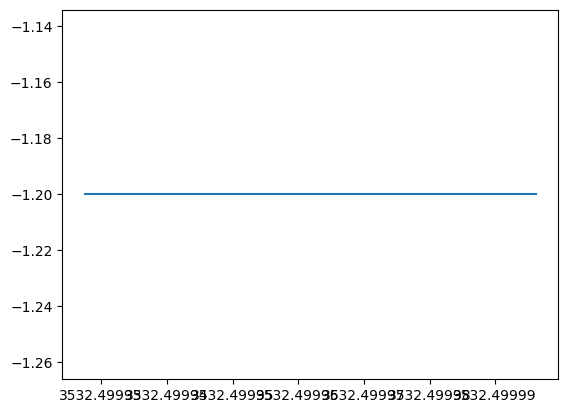

In [24]:
plt.plot(water0.get_freqs()[0:num_chnls], kurts)
# plt.ylim(-1.2001,-1.1999)

In [21]:
# Take kurt() of each element in wf.get_freqs()

kurtosis(water0.get_freqs()[0:2])
print(len(water0.get_freqs()))

# Need at least 3 frequencies in the channel for kurt() to work.

# How do we get 3 frequencies/channel? How many channels do we need to make?
# If there are N = 4194304 frequencies, then we need 1,398,101.333 ~~ 1,398,101 channels (not sure how
# rounding will be handled!)

4194304


In [25]:
water0_abr = Waterfall(os.path.normpath(filelist[0]), max_load = ml_list[0], f_start = 3526 , f_stop = 3533)

blimpy.io.base_reader WARNING  Setting f_stop = 3532.499996, since f_stop not given or not valid.
blimpy.io.base_reader WARNING  f_start=3526, f_stop=3533, t_start=0, t_stop=512, init=True


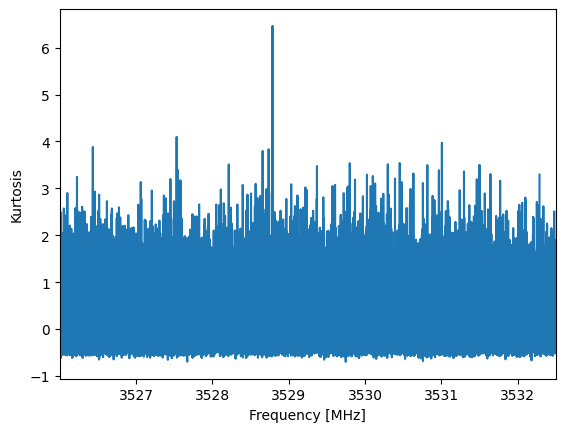

In [158]:
water0_abr.plot_kurtosis()

In [102]:
# Code modified from blimpy GitHub (plotting > plot_kurtosis.py)
wf = water0_abr
f_start = np.amin(wf.get_freqs())
f_stop = np.amax(wf.get_freqs())


plot_f, plot_data = wf.grab_data(f_start, f_stop, if_id=0)

# Using accending frequency for all plots.
if wf.header['foff'] < 0:
        plot_data = plot_data[..., ::-1]  # Reverse data
        plot_f = plot_f[::-1]

# try:
pltdata = kurtosis(plot_data, axis=0, nan_policy='omit')
# except:
#     pltdata = plot_data * 0.0
    

# print(plot_f[0], plot_f[-1])
print(pltdata)

# print(len(plot_data))

[ 0.47625828 -0.13222933  0.6003506  ...  0.04624271 -0.2579801
  0.32947755]


In [103]:
print(len(pltdata), len(water0.get_freqs()))

851968 4194304


In [104]:
sig_list = pltdata[np.where(pltdata > 3)]
print(sig_list)


# Make sure you use plot_f and NOT wf.get_freqs() because the order of wf.get_freqs() is decreasing,
# but we want it to be increasing!
sig_freqs = plot_f[np.where(pltdata > 3)]

[3.2434425 3.8816586 3.1341295 3.19694   4.0967464 3.4022956 3.0526323
 3.164588  3.166801        inf 3.5075154 3.0723891 3.0956354 3.7970862
 3.834484  6.4621    3.0864758 3.019012  3.4733815 3.0502224 3.0730796
 3.0256214 3.0479145 3.5359287 3.1873703 3.2907758 3.0481367 3.2624302
 3.103744  3.5138254 3.2085538 3.5398455 3.1312375 3.3175197 3.113266
 3.4951544 3.3857303 3.9709535 3.3616714 3.1952715 3.499682  3.3039317
 3.1638112       inf       inf       inf 3.2933726       inf       inf
       inf]


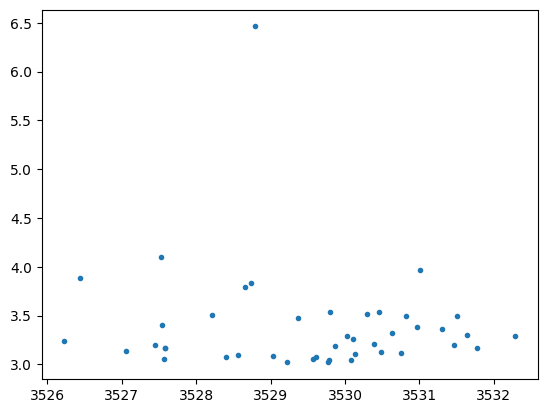

In [101]:
plt.plot(sig_freqs, sig_list, '.')

In [71]:
print(np.shape(plot_data))

(512, 851968)


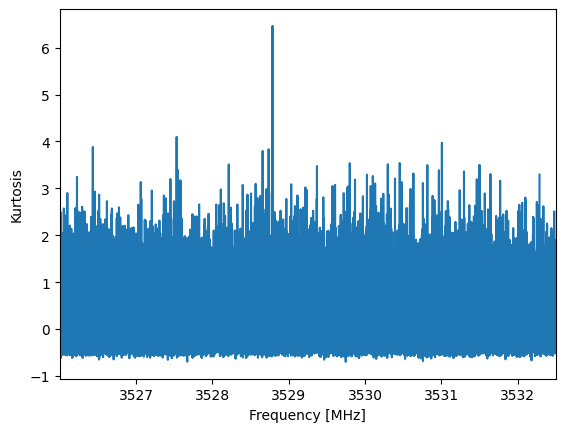

In [72]:
plt.plot(plot_f, pltdata)
plt.xlim(plot_f[0], plot_f[-1])
plt.ylabel("Kurtosis")
plt.xlabel("Frequency [MHz]")
plt.show()

In [ ]:
water0.plot_kurtosis()

In [110]:
water0_abr.get_kurtosis()

AttributeError: 'Waterfall' object has no attribute 'get_kurtosis'

In [87]:
# Grouping channels
# chnl = water0.freqs[div[i-1]:div[i]]

# print(water0.freqs[0:2])


def channel_kurtosis(arr, min, max):
    chnl = ma.masked_outside(arr, min, max)
    return kurtosis(chnl)


for i, j in enumerate(range(0, len(all_channels[0]))):
    exec(f'channel_kurtosis(water{i}.get_freqs(), min_f, max_f)')

print(channel_kurtosis(water0.get_freqs(), 3501, 3506),
      np.amax(water0.get_freqs()),
      np.amin(water0.get_freqs()))

/lustre/aoc/students/jsofair/jnrao/lib/python3.8/site-packages/scipy/stats/_stats_py.py:1417: RuntimeWarning: Mean of empty slice.
  mean = a.mean(axis, keepdims=True)
/lustre/aoc/students/jsofair/jnrao/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/lustre/aoc/students/jsofair/jnrao/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/lustre/aoc/students/jsofair/jnrao/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


NameError: name 'water6' is not defined

In [ ]:
# i = 0 # i goes through the waterN
# j = 0 # j goes through the elements of the waterN borders
# while i <= len(water0.freqs)-2:
#     chnl = ma.masked_outside(water0.freqs, all_channels[i][j], all_channels[i][j+1])
#     print(chnl)
#     i += 2
#     j += 1
print(ma.masked_outside(water0.freqs, 3501, 3506))
print(kurtosis(ma.masked_outside(water0.freqs, 3501, 3506)))

# indeces = np.where((water0.freqs > 3501) & (water0.freqs < 3506))
a = water0.freqs[indeces]
print(kurtosis(a), kurtosistest(a))
print(a, len(a))
len(water0.freqs)

In [ ]:
# print(all_channels[0][0], all_channels[0][1])

# chnl = water0.freqs
# print(chnl)
# for i, water in enumerate(all_channels):
#     for j, div in enumerate(water0.freqs):
#         print(div)
#         chnl = water[0:div]
#         print(chnl)

**Step 3:** Create an array that contains all channels with kurtosis > 0 (scipy uses the Fisher definition by default)

**Step 4:** Compare these channels with Dept. of Commerce graph to see where RFI might be coming in

**Step 5:** Will also compare to waterN+1.freqs, etc. to see common threads to identify RFI
    